In [8]:
import os
import re
import random
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import gensim
from konlpy.tag import Mecab
mecab = Mecab()










In [9]:
# 데이터 로드 및 전처리

data_dir = os.path.join(os.getenv('HOME'), 'aiffel/transformer_chatbot/data')
csv_path = os.path.join(data_dir, "ChatbotData.csv")

df = pd.read_csv(csv_path)
questions = df['Q'].tolist()  # 질문
answers   = df['A'].tolist()  # 답변

print("총 질문 수:", len(questions))
print("총 답변 수:", len(answers))

def preprocess_sentence(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r"[^a-z0-9가-힣\s\.\,\?\!']", "", sentence)
    sentence = re.sub(r'\s+', ' ', sentence).strip()
    return sentence



총 질문 수: 11823
총 답변 수: 11823


In [10]:
# Word2Vec 모델 로드

path2 = os.path.join(data_dir, "ko2.bin")
model = gensim.models.Word2Vec.load(path2)
wv = model.wv
print("모델 로드 성공!")



모델 로드 성공!


In [11]:
# 원본 CSV 문장에 직접 augmentation 수행

def lexical_sub_raw(sentence, wv, p=0.6, min_length=2):
    proc = preprocess_sentence(sentence)
    tokens = proc.split()
    if not tokens:
        return sentence
    if random.random() < p:
        # 후보: 길이>=min_length, 공백 없는 토큰, wv에 존재하는 토큰만
        candidates = [tok for tok in tokens if len(tok) >= min_length and tok in wv and (' ' not in tok)]
        if not candidates:
            return sentence
        selected_tok = random.choice(candidates)
        sim_list = wv.most_similar(selected_tok)
        # 공백이 없고 길이 조건을 만족하는 유사어 필터링
        sim_list = [w for (w, score) in sim_list if (' ' not in w) and (len(w) >= min_length)]
        if not sim_list:
            return sentence
        similar_word = random.choice(sim_list)
        new_tokens = [similar_word if tok == selected_tok else tok for tok in tokens]
        return " ".join(new_tokens)
    return sentence

# 최종 데이터 쌍을 (1) 원본, (2) Aug Q + 원본 A, (3) 원본 Q + Aug A로 생성
final_que = []
final_ans = []
N = len(questions)
for i in range(N):
    # (1) 원본
    final_que.append(questions[i])
    final_ans.append(answers[i])
    # (2) Augmented 질문, 원본 답변
    aug_q = lexical_sub_raw(questions[i], wv, p=0.6)
    final_que.append(aug_q)
    final_ans.append(answers[i])
    # (3) 원본 질문, Augmented 답변
    aug_a = lexical_sub_raw(answers[i], wv, p=0.6)
    final_que.append(questions[i])
    final_ans.append(aug_a)

print("최종 질문 개수:", len(final_que))
print("최종 답변 개수:", len(final_ans))
# 예시 출력
for i in range(20):
    print(f"[{i}] Q: {final_que[i]}")
    print(f"     A: {final_ans[i]}")


최종 질문 개수: 35469
최종 답변 개수: 35469
[0] Q: 12시 땡!
     A: 하루가 또 가네요.
[1] Q: 12시 땡!
     A: 하루가 또 가네요.
[2] Q: 12시 땡!
     A: 하루가 또 가네요.
[3] Q: 1지망 학교 떨어졌어
     A: 위로해 드립니다.
[4] Q: 1지망 여학교 떨어졌어
     A: 위로해 드립니다.
[5] Q: 1지망 학교 떨어졌어
     A: 위로해 드립니다.
[6] Q: 3박4일 놀러가고 싶다
     A: 여행은 언제나 좋죠.
[7] Q: 3박4일 놀러가고 싶다
     A: 여행은 언제나 좋죠.
[8] Q: 3박4일 놀러가고 싶다
     A: 여행은 결코 좋죠.
[9] Q: 3박4일 정도 놀러가고 싶다
     A: 여행은 언제나 좋죠.
[10] Q: 3박4일 정도 놀러가고 싶다
     A: 여행은 언제나 좋죠.
[11] Q: 3박4일 정도 놀러가고 싶다
     A: 여행은 기분 좋죠.
[12] Q: PPL 심하네
     A: 눈살이 찌푸려지죠.
[13] Q: PPL 심하네
     A: 눈살이 찌푸려지죠.
[14] Q: PPL 심하네
     A: 눈살이 찌푸려지죠.
[15] Q: SD카드 망가졌어
     A: 다시 새로 사는 게 마음 편해요.
[16] Q: SD카드 망가졌어
     A: 다시 새로 사는 게 마음 편해요.
[17] Q: SD카드 망가졌어
     A: 다시 새로 사는 게 마음 편해요.
[18] Q: SD카드 안돼
     A: 다시 새로 사는 게 마음 편해요.
[19] Q: SD카드 안돼
     A: 다시 새로 사는 게 마음 편해요.


In [12]:
# 데이터 토큰화 (Mecab 사용)

# 원본 증강된 문장을 Mecab으로 토큰화
tokenized_final_que = [mecab.morphs(preprocess_sentence(q)) for q in final_que]
tokenized_final_ans = [mecab.morphs(preprocess_sentence(a)) for a in final_ans]

print("토큰화된 질문 예시:", tokenized_final_que[:3])
print("토큰화된 답변 예시:", tokenized_final_ans[:3])


토큰화된 질문 예시: [['12', '시', '땡', '!'], ['12', '시', '땡', '!'], ['12', '시', '땡', '!']]
토큰화된 답변 예시: [['하루', '가', '또', '가', '네요', '.'], ['하루', '가', '또', '가', '네요', '.'], ['하루', '가', '또', '가', '네요', '.']]


단어 사전 크기: 8353
인코더 입력 shape: (35469, 40)
디코더 입력 shape: (35469, 40)


Epoch 1:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 1: 평균 Loss = 3.6401


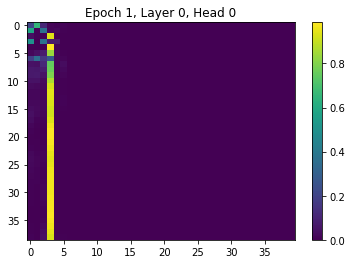

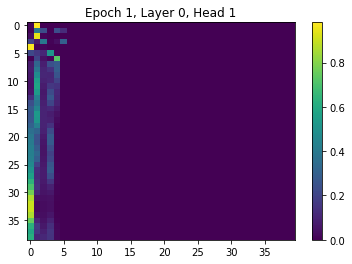

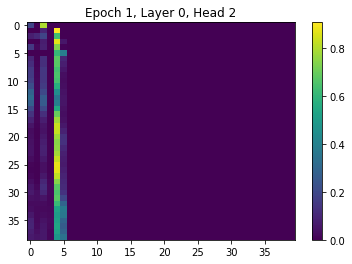

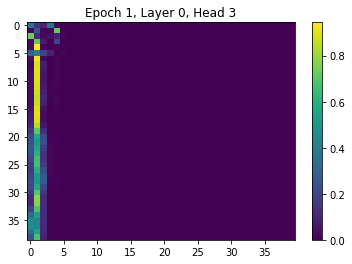

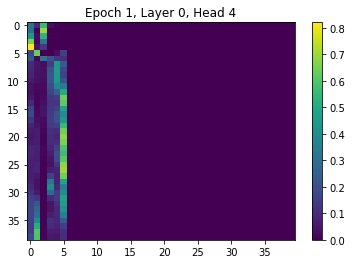

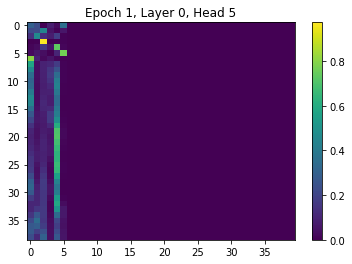

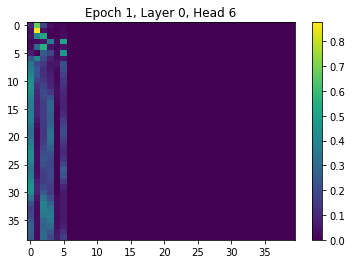

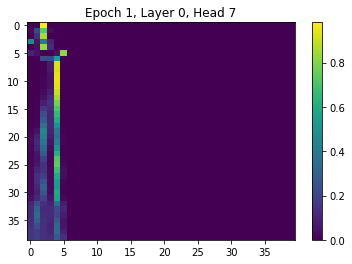


[Epoch 1] 챗봇 예시 결과:
Q: 지루하다, 놀러가고 싶어.
A: 하 세요 . 친구 한테 물 어 보 세요 . 친구 한테 물 어 보 세요 . 말 세요 . 말 해 보 세요 . 세요 . 말 세요 . 말 해 보 세요 . 세요 . 말 고 살
-----
Q: 오늘 일찍 일어났더니 피곤하다.
A: 이 그렇게 하 세요 . 생각 하 세요 . 저 한테 물 어 보 세요 . 기대 세요 . 기대 세요 . 곧 . 곧 . 곧 하 세요 . 곧 . 곧 . 곧 하 세요 . 곧 에서
-----
Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 만 부리 면 좋 아요 . 저 한테 말 해 봐요 . 자신 의 사랑 해 주 세요 . 이해 해 주 세요 . 지켜보 세요 . 지켜보 . 자신 을 해 주 세요 . 친구 만 주 세요 .
-----
Q: 집에 있는다는 소리야.
A: 이 클 때 요 . 어느덧 에 자신 의 인생 은 자신 에 요 . 어느덧 에 이해 해 보 세요 . 자신 을 자신 으로 물 어 보 세요 . 자신 에 세요 . 친구 으로 다가가 보 세요
-----


Epoch 2:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 2: 평균 Loss = 1.4297


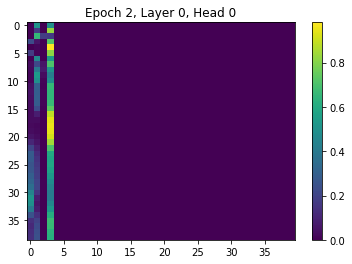

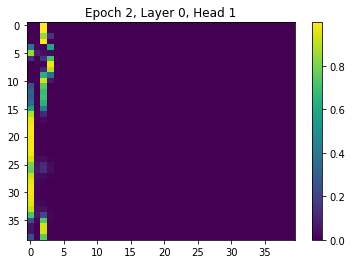

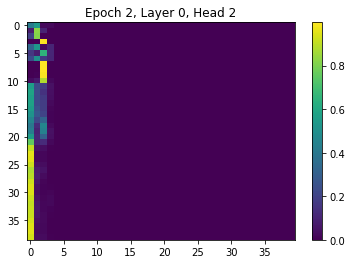

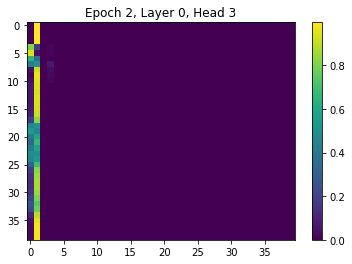

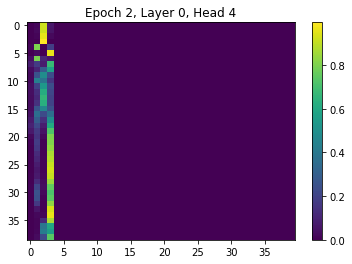

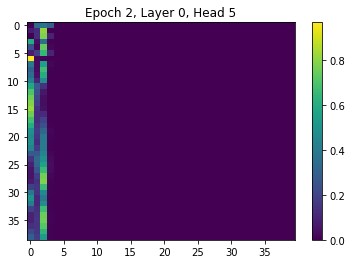

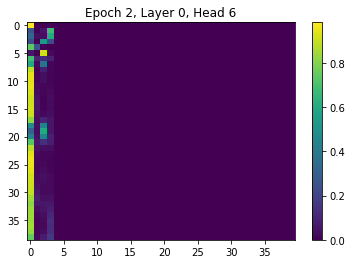

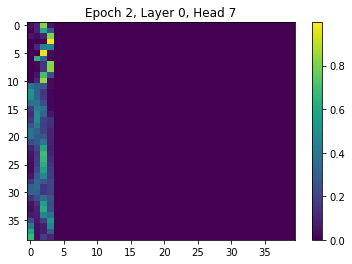


[Epoch 2] 챗봇 예시 결과:
Q: 지루하다, 놀러가고 싶어.
A: 들 어 보 고 있 네요 . 전화 해 보 세요 . 용기 를 내 세요 . 말 해 보 세요 . 먼저 봐요 . 말 해 보 세요 . 말 해 보 세요 . 말 해 보 세요 .
-----
Q: 오늘 일찍 일어났더니 피곤하다.
A: 말 해 보 세요 . 생각 하 세요 . 생각 하 세요 . 생각 하 세요 . 생각 하 세요 . 생각 하 세요 . 생각 하 세요 . 말 이 별 이 별 일 이 별 이 별 이
-----
Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 하 는 사람 이 좋 네요 . 전화 해 보 세요 . 당신 도 좋 아요 . 분위기 도 . 미련 도 . 미련 도 . 말 도 . 분위기 도 . 미련 도 . 미련 도 . 분위기 도
-----
Q: 집에 있는다는 소리야.
A: 해 주 세요 . 풀리 지 않 네요 . ? 게 차 든 자신 이 좋 아요 . ? 게 좋 지 않 아요 . 차 건 아니 에요 . 명 ? 안 요 . ? 안 요 . ?
-----


Epoch 3:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 3: 평균 Loss = 0.8618


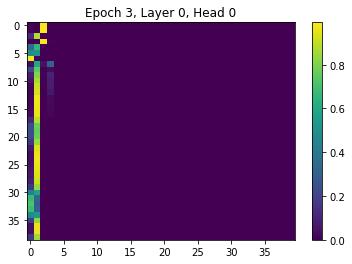

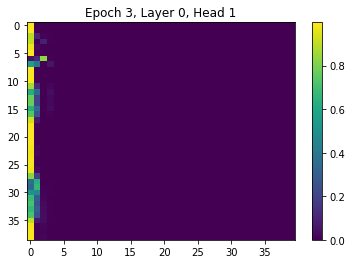

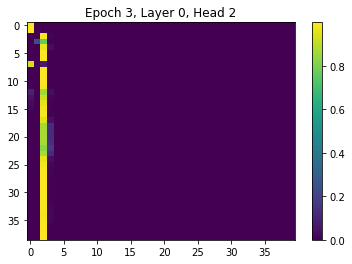

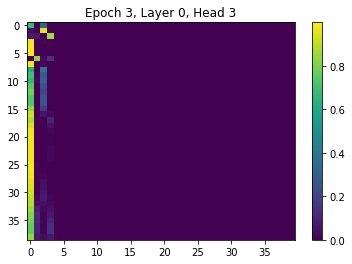

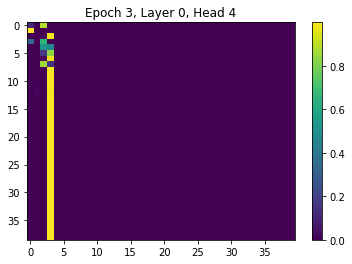

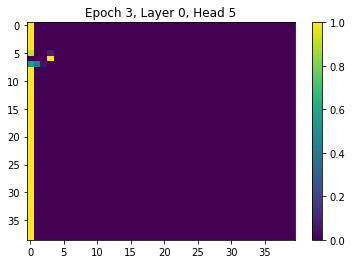

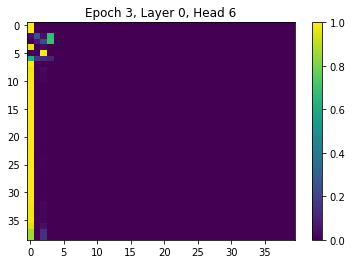

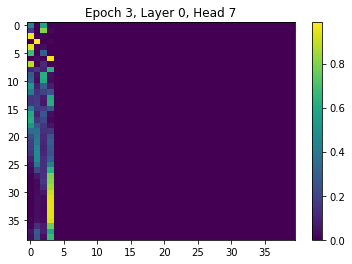


[Epoch 3] 챗봇 예시 결과:
Q: 지루하다, 놀러가고 싶어.
A: 에 부탁 해 보 세요 . 기분 을 좀 괜찮 아요 . 생각 할 수 도 있 어요 . 차분히 생각 해 보 세요 . 곳 해 보 세요 . 걸로 정리 오 세요 . 안 하 세요 . 차분히
-----
Q: 오늘 일찍 일어났더니 피곤하다.
A: 이 죠 . 생각 이 자유 로워질 까요 . 자신감 을 가지 세요 . 미련 도 이 에요 . 생각 해요 . 생각 해 보 세요 . 생각 해 보 세요 . 생각 하 려 생각 해요 . 생각 하
-----
Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 하 기 좋 은 없 어요 . 단지 느껴질 뿐 . 자연 스러운 현상 이 에요 . 내 이야기 해요 . ... 하 면 자연 스럽 게 해요 . 그래도 그 일 거 예요 . ... 은 없 다고 하
-----
Q: 집에 있는다는 소리야.
A: 들 어 보 고 싶 은 마음 먹 죠 . 내 세요 . 같이 하 세요 . 들 어 보 세요 . 곳 에서 행복 해요 . 무시 하 게 만들 면 좋 은 것 은 날 이 많 아요
-----


Epoch 4:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 4: 평균 Loss = 0.5026


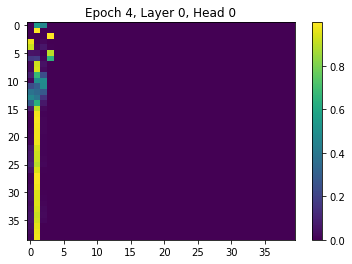

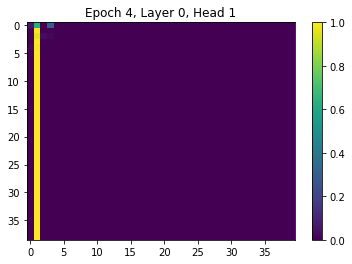

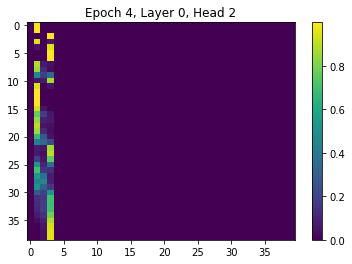

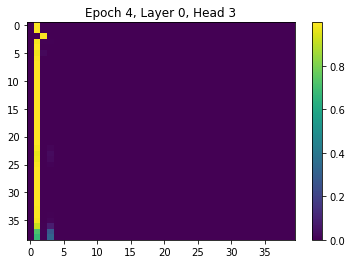

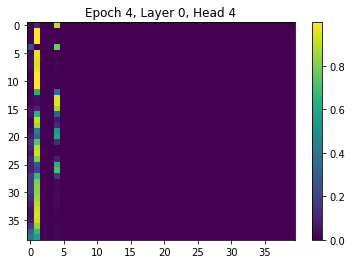

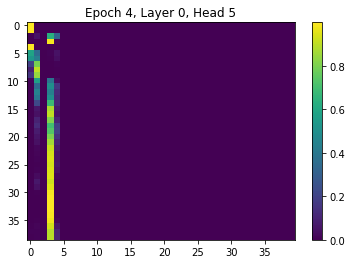

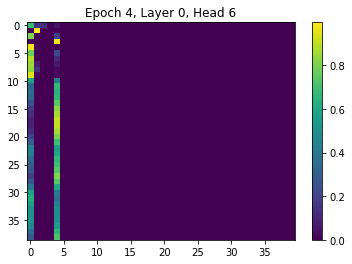

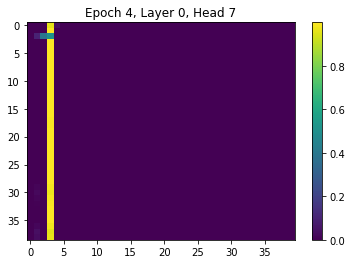


[Epoch 4] 챗봇 예시 결과:
Q: 지루하다, 놀러가고 싶어.
A: 을 좋아하 는지 물 어 보 세요 . 기분 을 접 어 두 세요 . 같이 해 보 세요 . 될 것 같 아요 . 좋 은 날 해 보 세요 . 좋 은 믿 으세요 . 좋 은 날
-----
Q: 오늘 일찍 일어났더니 피곤하다.
A: 이 라 생각 해요 . 새로운 시작 응원 합니다 . 기분 이 생각 하 세요 . 이 라 생각 해요 . 생각 해요 . 생각 해요 . 느껴 지 않 나 의 실수 했 나 . 생각 해요 . 생각
-----
Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 은 러 가 는 거 죠 . 데이트 하 기 편하 거 예요 . 데이트 은 사람 에 많 은 없 다고 든 의사 는 게 좋 죠 . 데이트 죠 . 데이트 은 것 같 아요 . 데이트 은
-----
Q: 집에 있는다는 소리야.
A: ! 힘내 요 . 같이 놀 러 가 되 었 나 봐요 . 저 에게 좋 아요 . 저 에게 기대 세요 . 당장 좋 아요 . 당장 좋 은 일 들 이 라고 말 아요 . 당장 같이 당신
-----


Epoch 5:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 5: 평균 Loss = 0.3386


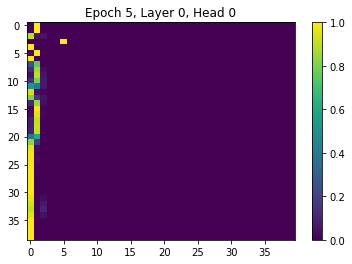

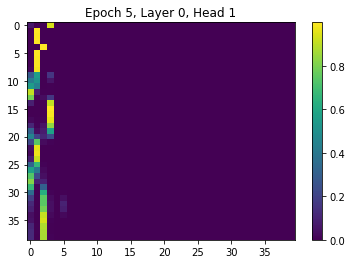

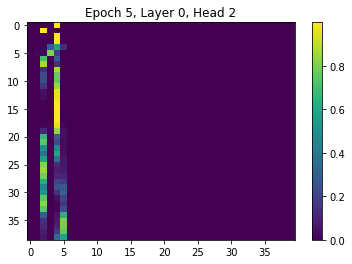

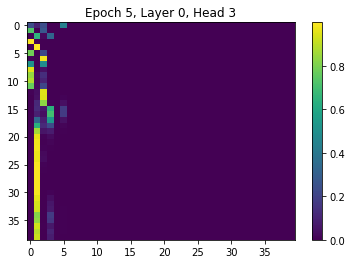

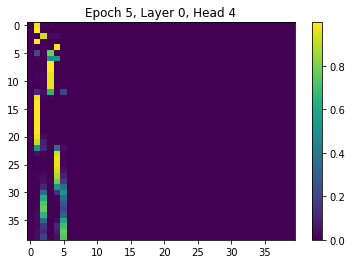

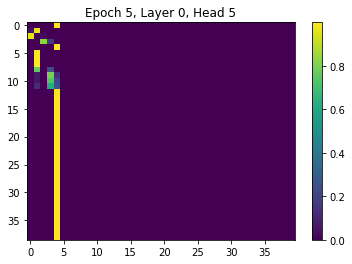

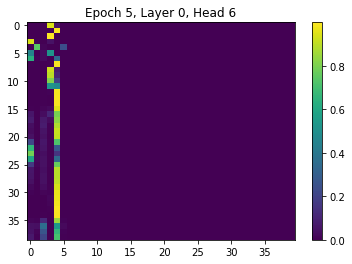

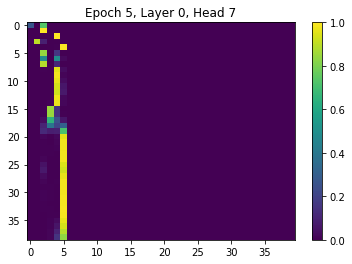


[Epoch 5] 챗봇 예시 결과:
Q: 지루하다, 놀러가고 싶어.
A: 에 도와 드릴게요 . 같 아요 . 저 도 . 좋 은 날 은 날 은 것 같 아요 . 좋 은 일 수 도 있 어요 . 좋 을 거 예요 . 좋 을 것 같 아요 . 좋
-----
Q: 오늘 일찍 일어났더니 피곤하다.
A: 에 맞 는 실수 를 했 나 봐요 . 곧 . 곧 고통 을 놓 는 것 이 실망 했 네요 . 진지 했 나 봐요 . 말 는 것 같 아요 . 체조 를 들 무시 하 셨 나요
-----
Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 한 명 장만 는 건 어떨까 요 . 새로운 시작 . 새로운 이야기 를 놓 고 사랑 해 주 세요 . 용기 내 있 은 거 예요 . 그런 거 예요 . 놓 고 있 을 놓 고 이별 하
-----
Q: 집에 있는다는 소리야.
A: 들 어 드릴게요 . 당신 을 돌보 길 바랍니다 . . 당신 . 당신 곁 에 맞 아요 . 원 하 는 것 을 . 좋 은 일 그 사람 들 이 라고 . 좋 은 구경 별로 . 좋
-----


Epoch 6:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 6: 평균 Loss = 0.2613


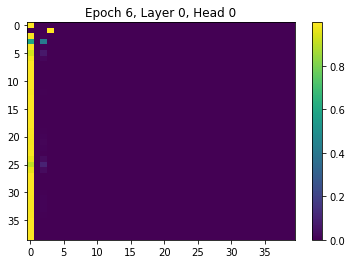

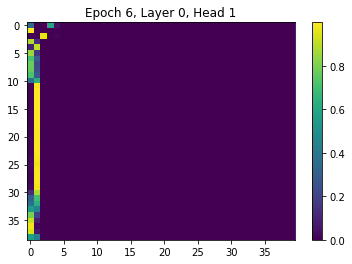

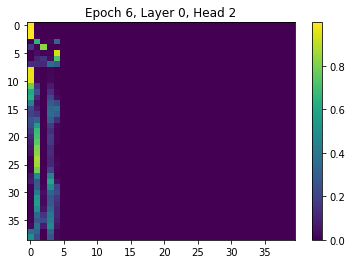

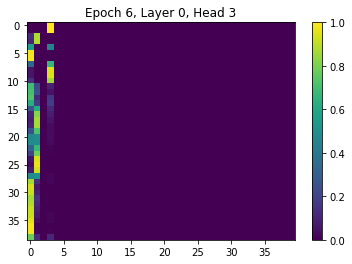

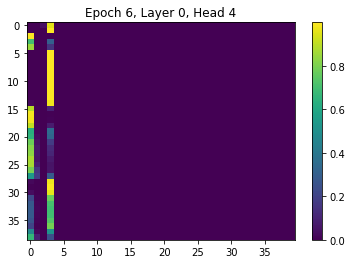

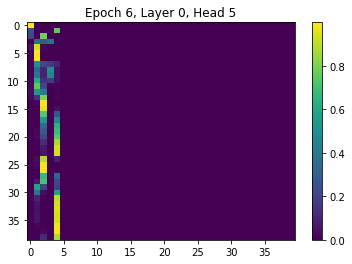

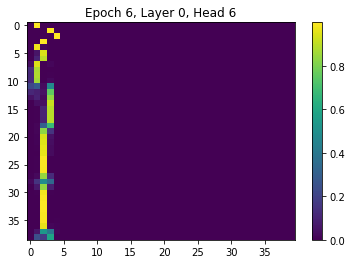

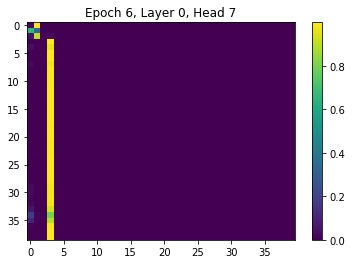


[Epoch 6] 챗봇 예시 결과:
Q: 지루하다, 놀러가고 싶어.
A: 만 어떨까 요 . 놀 러 가 는 거 예요 . 새로운 인연 이 죠 . 어요 . 어요 . 어요 . 칭찬 해 보 세요 . 칭찬 . 그러 세요 . 놀 아요 . 어요 . 어요 . 어요
-----
Q: 오늘 일찍 일어났더니 피곤하다.
A: 에 따라 라 생각 해요 . 곧 . 용기 를 내 요 . 새로운 했 어요 . . . . . . . . . . . . . . . . . . . . 새로운 인연 이 별
-----
Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 아도 괜찮 아요 . 모른 척하 세요 . 세요 . . . 새로운 인연 을 했 어요 . 자신 을 믿 어 주 세요 . 것 같 아요 . 무엇 말 아요 . 용기 . 그만큼 사람 에게 좋 은
-----
Q: 집에 있는다는 소리야.
A: 집 에 있 죠 . 자연 스러운 현상 이 에요 . 어제 어 보 세요 . 같이 라면 들 맛있 세요 . 요 . 요 . 요 . 같이 라면 드릴게요 . 그래도 그 순간 을 보여 . 좋 아요
-----


Epoch 7:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 7: 평균 Loss = 0.2110


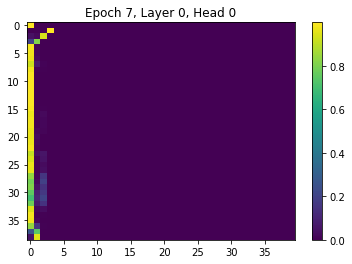

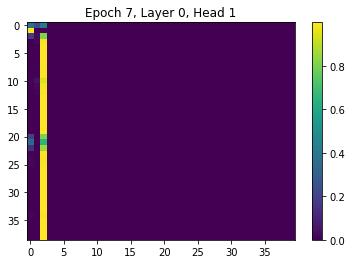

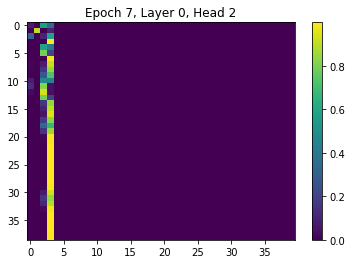

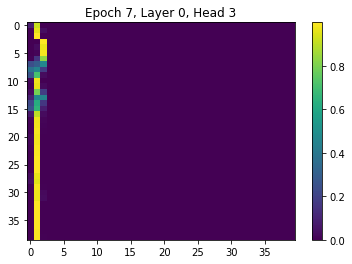

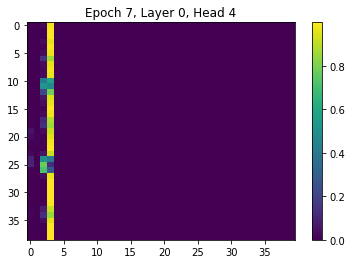

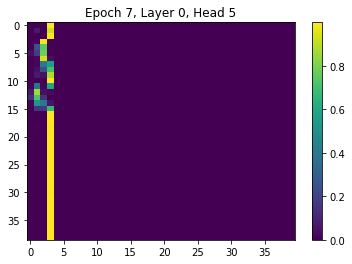

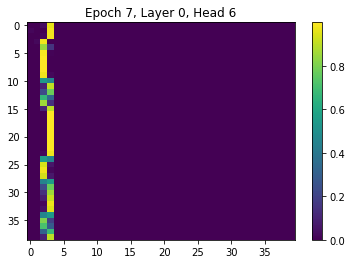

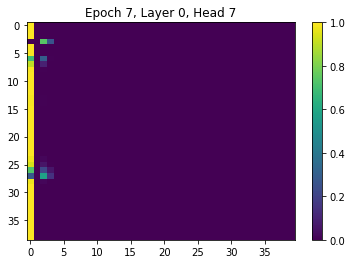


[Epoch 7] 챗봇 예시 결과:
Q: 지루하다, 놀러가고 싶어.
A: 놀 러 가 세요 . 생각 해 보 세요 . 눈치 가 세요 . 생각 해 볼게요 . 눈치 . 정리 될 것 같 아요 . 좋 아요 . 좋 아요 . 좋 아요 . 좋 아요 . 좋 아요
-----
Q: 오늘 일찍 일어났더니 피곤하다.
A: 에 따라 다른 관계 였 나요 . 용기 가 필요 하 죠 . 용기 를 내 요 . 용기 내 . 용기 내 풀 어야 해요 . 용기 내 . 용기 내 . 용기 를 내 . 용기 내 .
-----
Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 한 순간 은 없 을 거 예요 . 친구 해도 좋 을 거 예요 . 용기 를 내 . 용기 일 은 곳 으로 아요 . 여행 할 수 있 을 거 예요 . 용기 를 내 . 용기 를
-----
Q: 집에 있는다는 소리야.
A: 들 어 드릴게요 . 어디 . 을 받아들이 는 것 같 아요 . 필요 하 지 않 아요 . 본인 의 예요 . 좋 아요 . 본인 이 네요 . 저 한테 배워 . 같이 있 지 않 아요 .
-----


Epoch 8:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 8: 평균 Loss = 0.1762


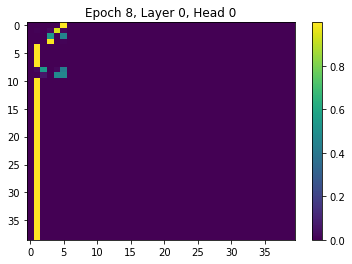

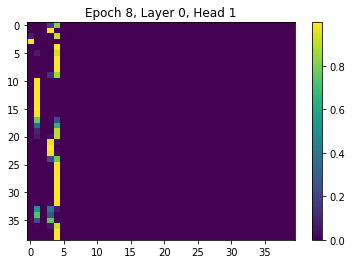

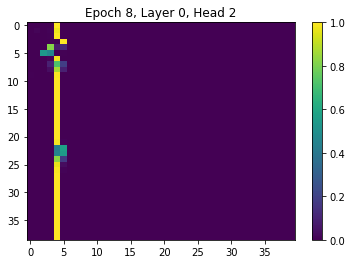

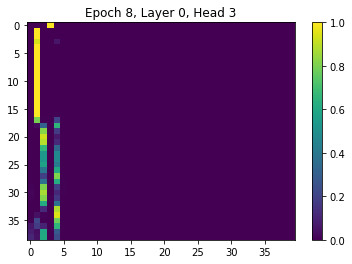

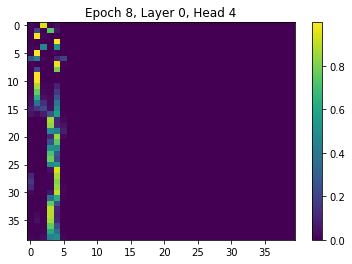

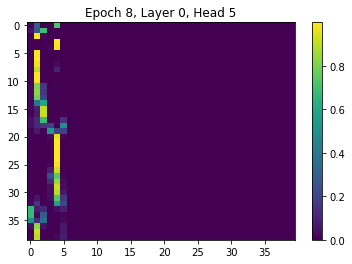

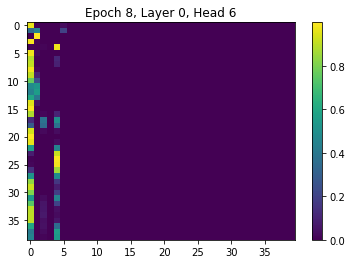

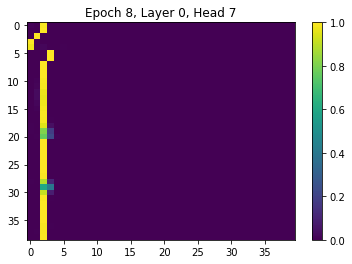


[Epoch 8] 챗봇 예시 결과:
Q: 지루하다, 놀러가고 싶어.
A: 에 따라 다르 겠 지요 . 다른 곳 . 을 좀 더 힘들 어 보 세요 . 아픈 말 해 줄 예요 . 아픈 일 것 같 아요 . 도 좋 아요 . 생각 해 줄 에요 . 아픈 일
-----
Q: 오늘 일찍 일어났더니 피곤하다.
A: 꿈 이 되 었 나 봐요 . 누구 나 좋 죠 . 만날 수 있 을 거 예요 . 봅니다 . 봅니다 . 봅니다 . 봅니다 . . 했 나 봅니다 . . . . 봅니다 . 봅니다 . 봅니다
-----
Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 은 긴 원한다면 친구 해도 돼요 . 친구 를 내 서 고백 하 세요 . 힘들 어 . 친구 를 해 보 세요 . 친구 들 과 연락 하 세요 . 친구 를 통해 세요 . 친구 를 꼭 일
-----
Q: 집에 있는다는 소리야.
A: 들 어 드릴게요 . 많 아요 . 같이 있 네요 . 많 은 새로운 버텨 보 세요 . 세요 . 좋 세요 . 좋 세요 . 좋 세요 . 좋 겠 네요 . 좋 세요 . 좋 겠 죠 .
-----


Epoch 9:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 9: 평균 Loss = 0.1530


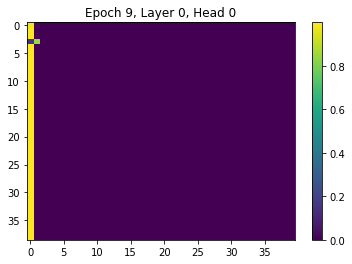

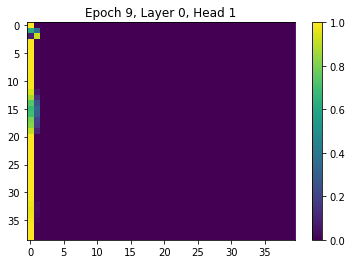

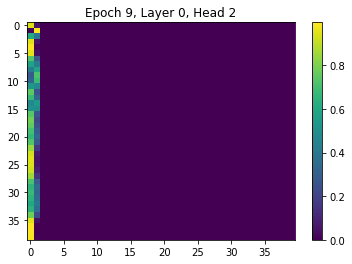

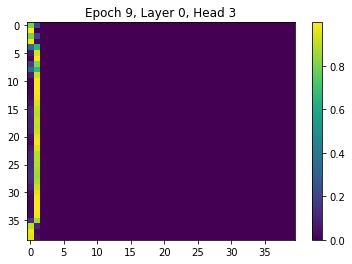

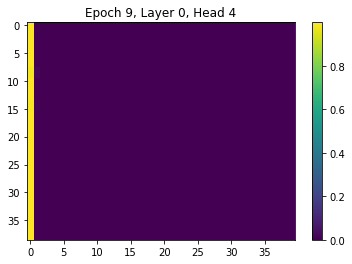

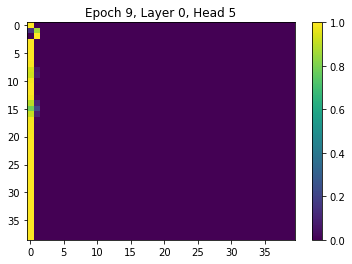

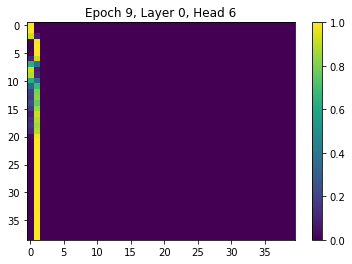

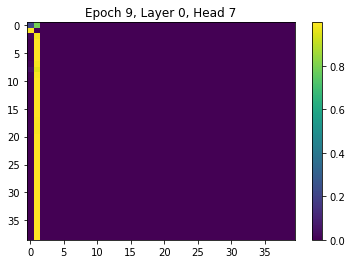


[Epoch 9] 챗봇 예시 결과:
Q: 지루하다, 놀러가고 싶어.
A: 에 요 . 같이 가요 . 영화 를 괴롭 게 해요 . 영화 를 칭찬 해 보 세요 . 이야기 해 보 세요 . 할 수 있 어요 . 영화 인 것 같 아요 . 영화 인 것 같 아요
-----
Q: 오늘 일찍 일어났더니 피곤하다.
A: 제 가 축하 해 주 실 거 예요 . 저 기분 들 했 던 일 이 니까요 . . . . . . . 했 나 봐요 . 했 나 . . . . . . . . 고통 이
-----
Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 은 데이트 신청 멋지 네요 . 데이트 . 데이트 하 세요 . 데이트 하 세요 . 사람 입니다 . 아니 . 대단 . 대단 하 세요 . 대단 하 시 길 바랍니다 . . . . . . . .
-----
Q: 집에 있는다는 소리야.
A: 에 요 . 같이 있 다고 믿 어요 . 집 . 에 . 자연 스럽 게 말 하 게 이야기 를 시간 이 요 . 있 죠 . 보내 요 . 보내 요 . 삶 을 거 예요 . 보내
-----


Epoch 10:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 10: 평균 Loss = 0.1346


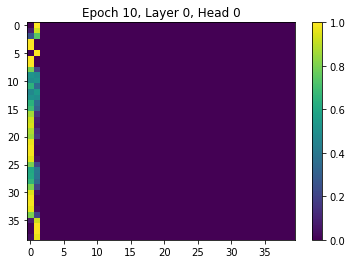

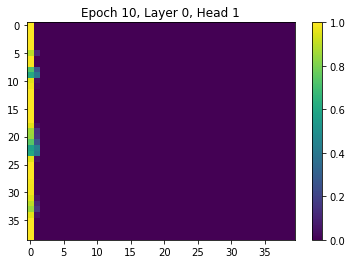

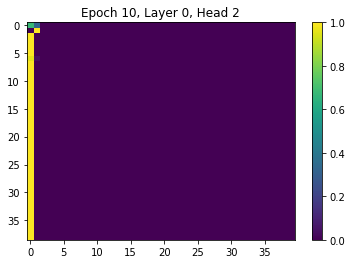

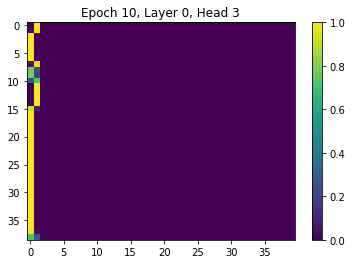

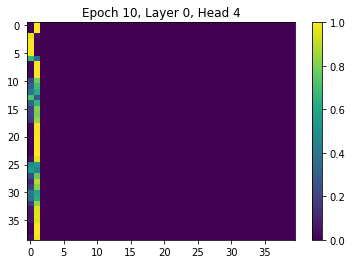

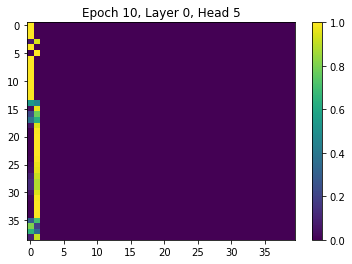

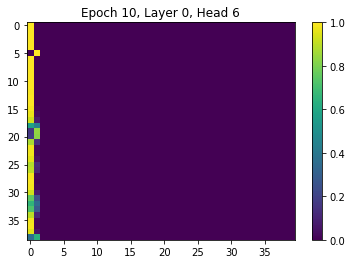

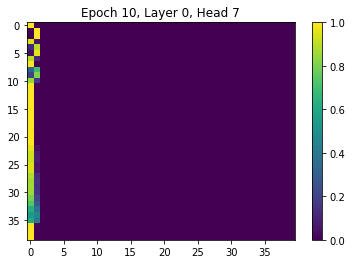


[Epoch 10] 챗봇 예시 결과:
Q: 지루하다, 놀러가고 싶어.
A: 에 부탁 드리 고 싶 네요 . 극복 해 보 세요 . 생각 이 정리 가 필요 하 지요 . 어 나가 세요 . 어요 . 에 어요 . 어요 . 요 . 걸로 . 걸로 , 이랑 어요 .
-----
Q: 오늘 일찍 일어났더니 피곤하다.
A: 일어날 시간 이 에요 . 신경 쓰 지 마세요 . 조금 씩 변화 시켜 . 용기 를 놓아주 세요 . 조금 씩 잊 . 조금 씩 변화 시켜 . 용기 일 적 노동 을 했 나 봅니다 . 용기 일
-----
Q: 간만에 여자친구랑 데이트 하기로 했어.
A: , 연락 을 바뀌 길 바랍니다 . 절대 . 절대 . 절대 같이 응원 해요 . 믿 어 주 세요 . 믿 어 보 세요 . 믿 어 보 세요 . 믿 어 보 세요 . 믿 어 보 세요
-----
Q: 집에 있는다는 소리야.
A: 들 이 원하 지 않 는 게 좋 겠 네요 . 당신 에게 요 . 같이 놀 러 와 자신 을 더 사랑 해 주 세요 . 같이 하 세요 . 같이 하 세요 . 같이 하 면 미련 이
-----

--- BLEU 테스트 ---

--- BLEU 테스트 ---


  0%|          | 0/4 [00:00<?, ?it/s]

Source Sentence:  지루하다, 놀러가고 싶어.
Model Prediction:  ['검색', '해', '봐요', '.', '제', '가', '맞', '아요', '.', '용기', '내', '세요', '.', '용기', '를', '내', '세요', '.', '다른', '일', '이', '에요', '.', '용기', '.', '용기', '예요', '.', '용기', '예요', '.', '용기', '.', '용기', '예요', '.', '용기', '.', '용기', '예요']
Real:  ['잠깐', '쉬', '어도', '돼요', '.', 'end']
BLEU Score: 0.0046

Source Sentence:  오늘 일찍 일어났더니 피곤하다.
Model Prediction:  ['.', '..', '번', '생각', '해', '보', '세요', '.', '생각', '이', '정리', '되', '어', '.', '생각', '해', '.', '생각', '해', '봐요', '.', '생각', '해', '.', '생각', '해', '.', '생각', '해', '.', '생각', '해', '.', '생각', '해', '.', '생각', '해', '봐요', '.']
Real:  ['맛난', '거', '드세요', '.', 'end']
BLEU Score: 0.0046

Source Sentence:  간만에 여자친구랑 데이트 하기로 했어.
Model Prediction:  ['.', '죠', '.', '노력', '죠', '.', '죠', '.', '죠', '.', '노력', '.', '노력', '하', '는', '게', '더욱', '단단', '해', '지', '는', '과정', '은', '없', '죠', '.', '노력', '해', '지', '도', '않', '아요', '.', '상관', '세요', '.', '상관', '없', '을', '받아들이']
Real:  ['떨리', '겠', '죠', '.', 'end']
BLEU Score: 0.0098

Sourc

In [13]:
#단어 사전 구축 및 벡터화

all_sentences = tokenized_final_que + tokenized_final_ans
vocab = {"<pad>": 0, "<start>": 1, "<end>": 2}
for sentence in all_sentences:
    for token in sentence:
        if token not in vocab:
            vocab[token] = len(vocab)
inv_vocab = {v: k for k, v in vocab.items()}
print("단어 사전 크기:", len(vocab))

def tokenize_sentence(token_list, vocab):
    return [vocab.get(token, vocab["<pad>"]) for token in token_list]

que_seq = [tokenize_sentence(tokens, vocab) for tokens in tokenized_final_que]
ans_seq = [tokenize_sentence(tokens, vocab) for tokens in tokenized_final_ans]

MAX_LEN = 40
enc_train = tf.keras.preprocessing.sequence.pad_sequences(que_seq, maxlen=MAX_LEN, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(ans_seq, maxlen=MAX_LEN, padding='post')

print("인코더 입력 shape:", enc_train.shape)
print("디코더 입력 shape:", dec_train.shape)


# Step 6. Transformer 모델 정의 및 학습

def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, (2*(i//2)) / np.float32(d_model))
    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]
    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_lookahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_enc_mask = generate_padding_mask(src)
    dec_lookahead_mask = generate_lookahead_mask(tgt.shape[1])
    dec_tgt_padding_mask = generate_padding_mask(tgt)
    dec_mask = tf.maximum(dec_tgt_padding_mask, dec_lookahead_mask)
    return enc_mask, dec_enc_mask, dec_mask

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.depth = d_model // self.num_heads
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        self.linear = tf.keras.layers.Dense(d_model)
    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)
        scaled_qk = QK / tf.math.sqrt(d_k)
        if mask is not None: 
            scaled_qk += (mask * -1e9)
        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)
        return out, attentions
    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])
        return split_x
    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))
        return combined_x
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        out, attention_weights = self.scaled_dot_product_attention(WQ_splits, WK_splits, WV_splits, mask)
        out = self.combine_heads(out)
        out = self.linear(out)
        return out, attention_weights

class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)
    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
        return out

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)
        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.do = tf.keras.layers.Dropout(dropout)
    def call(self, x, mask):
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        return out, enc_attn

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)
        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.do = tf.keras.layers.Dropout(dropout)
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(Q=out, K=enc_out, V=enc_out, mask=dec_enc_mask)
        out = self.do(out)
        out += residual
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        return out, dec_attn, dec_enc_attn

class Encoder(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)]
        self.do = tf.keras.layers.Dropout(dropout)
    def call(self, x, mask):
        out = x
        enc_attns = []
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        return out, enc_attns

class Decoder(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)]
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        out = x
        dec_attns = []
        dec_enc_attns = []
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = self.dec_layers[i](out, enc_out, dec_enc_mask, padding_mask)
            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)
        return out, dec_attns, dec_enc_attns

class Transformer(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, src_vocab_size,
                 tgt_vocab_size, pos_len, dropout=0.2, shared_fc=True, shared_emb=False):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        if shared_emb:
            self.enc_emb = self.dec_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)
        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)
        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.fc = tf.keras.layers.Dense(tgt_vocab_size)
        self.shared_fc = shared_fc
        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))
    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)
        if self.shared_fc:
            out *= tf.math.sqrt(self.d_model)
        out += self.pos_encoding[np.newaxis, :seq_len, :]
        out = self.do(out)
        return out
    def call(self, enc_in, dec_in, enc_mask, dec_enc_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)
        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        dec_out, dec_attns, dec_enc_attns = self.decoder(dec_in, enc_out, dec_enc_mask, dec_mask)
        logits = self.fc(dec_out)
        return logits, enc_attns, dec_attns, dec_enc_attns

n_layers = 1
d_model = 368
n_heads = 8
d_ff = 1024
dropout = 0.2
VOCAB_SIZE = len(vocab)
pos_len = 200

transformer = Transformer(
    n_layers=n_layers,
    d_model=d_model,
    n_heads=n_heads,
    d_ff=d_ff,
    src_vocab_size=VOCAB_SIZE,
    tgt_vocab_size=VOCAB_SIZE,
    pos_len=pos_len,
    dropout=dropout,
    shared_fc=True,
    shared_emb=True)

class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=1000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(d_model, warmup_steps=1000)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

@tf.function
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]
    gold = tgt[:, 1:]
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)
    with tf.GradientTape() as tape:
        predictions, _, _, _ = model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

def show_attention_maps(model, epoch, sample_src, sample_tgt_in):
    enc_mask, dec_enc_mask, dec_mask = generate_masks(sample_src, sample_tgt_in)
    predictions, enc_attns, dec_attns, dec_enc_attns = model(
        sample_src, sample_tgt_in, enc_mask, dec_enc_mask, dec_mask
    )
    for layer_idx, layer_attn in enumerate(dec_enc_attns):
        layer_attn = layer_attn[0].numpy()  # (num_heads, tgt_seq_len, src_seq_len)
        num_heads = layer_attn.shape[0]
        for head_idx in range(num_heads):
            single_head = layer_attn[head_idx]
            plt.figure()
            plt.imshow(single_head, aspect='auto')
            plt.title(f"Epoch {epoch+1}, Layer {layer_idx}, Head {head_idx}")
            plt.colorbar()
            plt.show()

BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train)).shuffle(10000).batch(BATCH_SIZE)

EPOCHS = 10
test_queries = [
    "지루하다, 놀러가고 싶어.",
    "오늘 일찍 일어났더니 피곤하다.",
    "간만에 여자친구랑 데이트 하기로 했어.",
    "집에 있는다는 소리야."
]

for epoch in range(EPOCHS):
    total_loss = 0
    dataset_count = tf.data.experimental.cardinality(train_dataset).numpy()
    tqdm_bar = tqdm(enumerate(train_dataset), total=dataset_count, desc=f"Epoch {epoch+1}")

    random_src, random_tgt = None, None

    for step, (src, tgt) in tqdm_bar:
        loss = train_step(src, tgt, transformer, optimizer)
        total_loss += loss

        if step == 0:
            random_src = src
            random_tgt = tgt

        if step % 50 == 0:
            tqdm_bar.set_postfix({"Loss": f"{loss.numpy():.4f}"})

    print(f"Epoch {epoch+1}: 평균 Loss = {total_loss / dataset_count:.4f}")

    if random_src is not None and random_tgt is not None:
        sample_src = random_src[:1]
        sample_tgt_in = random_tgt[:1, :-1]
        show_attention_maps(transformer, epoch, sample_src, sample_tgt_in)

    print(f"\n[Epoch {epoch+1}] 챗봇 예시 결과:")
    for q in test_queries:
        src_tokens = mecab.morphs(preprocess_sentence(q))
        src_idx = [vocab.get(tok, 0) for tok in src_tokens]
        padded_tokens = tf.keras.preprocessing.sequence.pad_sequences([src_idx], maxlen=MAX_LEN, padding='post')
        ids = []
        output = tf.expand_dims([vocab.get("<start>")], 0)
        for i in range(MAX_LEN):
            enc_padding_mask, combined_mask, dec_padding_mask = generate_masks(padded_tokens, output)
            predictions, _, _, _ = transformer(padded_tokens, output, enc_padding_mask, combined_mask, dec_padding_mask)
            predicted_id = tf.argmax(tf.nn.softmax(predictions, axis=-1)[0, -1]).numpy().item()
            if predicted_id == vocab.get("<end>"):
                break
            ids.append(predicted_id)
            output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)
        answer_tokens = [inv_vocab.get(i, "") for i in ids]
        print("Q:", q)
        print("A:", " ".join(answer_tokens))
        print("-----")

print("\n--- BLEU 테스트 ---")
def calculate_bleu(reference, candidate, weights=[0.25, 0.25, 0.25, 0.25]):
    return sentence_bleu([reference], candidate, weights=weights, smoothing_function=SmoothingFunction().method1)

def eval_bleu_single(model, src_sentence, tgt_sentence, tokenizer, verbose=True):
    src_tokens = tokenizer.encode(src_sentence)
    tgt_tokens = tgt_sentence.split()
    if len(src_tokens) > MAX_LEN or len(tgt_tokens) > MAX_LEN:
        return None
    reference = tgt_sentence.split()
    padded_tokens = tf.keras.preprocessing.sequence.pad_sequences([src_tokens], maxlen=MAX_LEN, padding='post')
    ids = []
    output = tf.expand_dims([tokenizer.bos_id()], 0)
    for i in range(MAX_LEN):
        enc_padding_mask, combined_mask, dec_padding_mask = generate_masks(padded_tokens, output)
        predictions, _, _, _ = transformer(padded_tokens, output, enc_padding_mask, combined_mask, dec_padding_mask)
        predicted_id = tf.argmax(tf.nn.softmax(predictions, axis=-1)[0, -1]).numpy().item()
        if predicted_id == tokenizer.eos_id():
            break
        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)
    candidate = [tokenizer.inv_vocab.get(i, "") for i in ids]
    score = sentence_bleu([reference], candidate, smoothing_function=SmoothingFunction().method1)
    if verbose:
        print("Source Sentence: ", src_sentence)
        print("Model Prediction: ", candidate)
        print("Real: ", reference)
        print("BLEU Score: %.4f\n" % score)
    return score

def eval_bleu(model, src_sentences, tgt_sentences, tokenizer, verbose=False):
    total_score = 0.0
    sample_size = len(src_sentences)
    for idx in tqdm(range(sample_size)):
        score = eval_bleu_single(model, src_sentences[idx], tgt_sentences[idx], tokenizer, verbose)
        if score is None:
            continue
        total_score += score
    print("Num of Sample:", sample_size)
    print("Average BLEU Score:", total_score / sample_size)

class SimpleTokenizer:
    def __init__(self, vocab, inv_vocab):
        self.vocab = vocab
        self.inv_vocab = inv_vocab
    def encode(self, sentence):
        tokens = sentence.split()
        return [self.vocab.get(tok, self.vocab["<pad>"]) for tok in tokens]
    def decode_ids(self, ids):
        return " ".join([self.inv_vocab.get(i, "") for i in ids])
    def bos_id(self):
        return self.vocab.get("<start>")
    def eos_id(self):
        return self.vocab.get("<end>")

tokenizer = SimpleTokenizer(vocab, inv_vocab)

print("\n--- BLEU 테스트 ---")
test_src = [preprocess_sentence(q) for q in test_queries]
test_tgt = [preprocess_sentence(a) for a in [
    "잠깐 쉬 어도 돼요 . <end>",
    "맛난 거 드세요 . <end>",
    "떨리 겠 죠 . <end>",
    "좋 아 하 면 그럴 수 있 어요 . <end>"
]]
eval_bleu(transformer, test_src, test_tgt, tokenizer, verbose=True)


In [14]:

# 예: 증강된 질문, 답변 살펴보기

print("===  증강 샘플 보기 ===")
sample_count = 12  # 예: 앞쪽 12개 = 4세트
for i in range(sample_count):
    print(f"[{i}] Q: {final_que[i]}")
    print(f"    A: {final_ans[i]}")

print("\n=== 원본 vs. 증강 구분해서 출력 ===")
for i in range(0, sample_count, 5):
    print(f"--- 세트 {i//3 + 1} ---")
    print(f"(원본)  Q: {final_que[i]}")
    print(f"(원본)  A: {final_ans[i]}")
    if i+1 < len(final_que):
        print(f"(AugQ)  Q: {final_que[i+1]}")
        print(f"(AugQ)  A: {final_ans[i+1]}")
    if i+2 < len(final_que):
        print(f"(AugA)  Q: {final_que[i+2]}")
        print(f"(AugA)  A: {final_ans[i+2]}")
    print()



===  증강 샘플 보기 ===
[0] Q: 12시 땡!
    A: 하루가 또 가네요.
[1] Q: 12시 땡!
    A: 하루가 또 가네요.
[2] Q: 12시 땡!
    A: 하루가 또 가네요.
[3] Q: 1지망 학교 떨어졌어
    A: 위로해 드립니다.
[4] Q: 1지망 여학교 떨어졌어
    A: 위로해 드립니다.
[5] Q: 1지망 학교 떨어졌어
    A: 위로해 드립니다.
[6] Q: 3박4일 놀러가고 싶다
    A: 여행은 언제나 좋죠.
[7] Q: 3박4일 놀러가고 싶다
    A: 여행은 언제나 좋죠.
[8] Q: 3박4일 놀러가고 싶다
    A: 여행은 결코 좋죠.
[9] Q: 3박4일 정도 놀러가고 싶다
    A: 여행은 언제나 좋죠.
[10] Q: 3박4일 정도 놀러가고 싶다
    A: 여행은 언제나 좋죠.
[11] Q: 3박4일 정도 놀러가고 싶다
    A: 여행은 기분 좋죠.

=== 원본 vs. 증강 구분해서 출력 ===
--- 세트 1 ---
(원본)  Q: 12시 땡!
(원본)  A: 하루가 또 가네요.
(AugQ)  Q: 12시 땡!
(AugQ)  A: 하루가 또 가네요.
(AugA)  Q: 12시 땡!
(AugA)  A: 하루가 또 가네요.

--- 세트 2 ---
(원본)  Q: 1지망 학교 떨어졌어
(원본)  A: 위로해 드립니다.
(AugQ)  Q: 3박4일 놀러가고 싶다
(AugQ)  A: 여행은 언제나 좋죠.
(AugA)  Q: 3박4일 놀러가고 싶다
(AugA)  A: 여행은 언제나 좋죠.

--- 세트 4 ---
(원본)  Q: 3박4일 정도 놀러가고 싶다
(원본)  A: 여행은 언제나 좋죠.
(AugQ)  Q: 3박4일 정도 놀러가고 싶다
(AugQ)  A: 여행은 기분 좋죠.
(AugA)  Q: PPL 심하네
(AugA)  A: 눈살이 찌푸려지죠.

